<a href="https://colab.research.google.com/github/xr-cc/proj-hsg-env-chal/blob/master/code/spatial_corr_CES3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A starter spatial correlation analysis of CES3 Bay Area data, 

Use *Pollution* as example.

Follow the tutorial in http://darribas.org/gds_scipy16/ipynb_md/04_esda.html.

Fix the usage of some packages (because PySal not working).

In [ ]:
! pip install geopandas
! pip install descartes

In [ ]:
!apt install libspatialindex-c4v5
!pip install pysal

In [ ]:
! pip install mapclassify

In [ ]:
! pip install libpysal

In [ ]:
! pip install esda

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
# import geopandas as gpd
import pandas as pd
import numpy as np
import os

from mpl_toolkits.axes_grid1 import make_axes_locatable

# import pysal as ps
# # from pysal.contrib.viz import mapping as maps

# import mapclassify as mc
# import libpysal as lps
# from esda.moran import Moran,Moran_Local

from matplotlib import colors

In [4]:
# grant access to Google Drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
# load data

dataPath = "/mnt/data/CES3/"
xls = pd.ExcelFile(dataPath+"CES3 - Bay Area.xlsx")
sheets = xls.sheet_names
print(sheets)


['CES 3.0 (2018 Update)', 'Data Dictionary', 'Missing&NAData', 'Demographic profile']


In [17]:
# load dataframes

df = pd.read_excel(xls, sheet_name=sheets[0])
df_dict = pd.read_excel(xls, sheet_name=sheets[1],skiprows=range(0,6)).dropna(thresh=2)
df_demo = pd.read_excel(xls, sheet_name=sheets[3], header=None,
                        names=['Census Tract','CES 3.0 Score','CES 3.0 Percentile','CES 3.0 Percentile Range','Total Population',
                               'California County','Age:<10','Age:11-64','Age:>65', 'Race:Hispanic','Race:White','Race:AfricanAmerican',
                               'Race:NativeAmerican','Race:Aisan','Race:Other'],skiprows=[0]).dropna()

df_dict_temp = df_dict.dropna()
var_char = df_dict_temp[df_dict_temp['CalEnviroScreen Category'].str.contains('Population')]['Variable Name'].drop_duplicates()
var_char = [v.rstrip() for v in var_char]
var_char.insert(0,'Census ID')
print(var_char)

# load geo dataframe
gdf = gpd.read_file(dataPath+"CES3June2018Update.shp")
gdf = gdf[gdf['tract'].isin(df['Census ID'])].reset_index(drop=True).rename(columns={'tract': 'Census ID'})

# join dataframes
gdf = gdf.merge(df[var_char], on='Census ID')

['Census ID', 'Asthma', 'Asthma Pctl', 'Low Birth Weight', 'Low Birth Weight Pctl', 'Cardiovascular Disease', 'Cardiovascular Disease Pctl', 'Education', 'Education Pctl', 'Linguistic Isolation', 'Linguistic Isolation Pctl', 'Poverty', 'Unemployment', 'Unemployment Pctl', 'Housing Burden', 'Housing Burden Pctl']


In [19]:
gdf.head()

,Census ID,pop2010,California,ZIP,City,Longitude,Latitude,CIscore,CIscoreP,ozone,ozoneP,pm,pmP,diesel,dieselP,drink,drinkP,pest,pestP,RSEIhaz,RSEIhazP,traffic,trafficP,cleanups,cleanupsP,gwthreats,gwthreatsP,haz,hazP,iwb,iwbP,swis,swisP,Pollution,PollutionS,PollutionP,asthma,asthmaP,lbw,lbwP,...,pov,povP,unemp,unempP,housingB,housingBP,PopChar,PopCharSco,PopCharP,Children_u,Pop_11_64_,Elderly_ov,Hispanic_p,White_pct,African_Am,Native_Ame,Asian_Amer,Other_pct,OBJECTID_1,CIdecile,CIvigintil,Shape_Leng,Shape_Area,CES2018_Rn,geometry,Asthma,Asthma Pctl,Low Birth Weight,Low Birth Weight Pctl,Cardiovascular Disease,Cardiovascular Disease Pctl,Education,Education Pctl,Linguistic Isolation,Linguistic Isolation Pctl,Poverty,Unemployment,Unemployment Pctl,Housing Burden,Housing Burden Pctl
0,6.085509e+09,4603,Santa Clara,94043,Mountain View,-122.074346,37.401206,19.89,38,0.035,17,9.96,43,28.58,83,277.40,29,0.000,0,252.02,40,1230.83,76,66.5,98,121.85,98,0.20,61,5,55,0.0,0,48.16,5.93,67,20.70,9,4.77,46,...,10.5,8,9.9,55,21.5,65,32.34,3.35,23,9.7,80.2,10.1,18.4,46.8,2.7,0.3,27.2,4.6,5110,4,8,5862.187357,1.581581e+06,35-40%,"POLYGON ((-182852.281 -67226.673, -182870.875 ...",20.70,8.839297,4.77,45.802896,6.48,30.270540,5.0,19.707292,4.6,33.902146,10.5,9.9,55.298896,21.5,65.143437
1,6.085510e+09,4688,Santa Clara,94022,Los Altos,-122.120112,37.392783,3.53,1,0.035,17,9.96,43,19.90,61,465.27,48,0.056,16,202.20,36,566.07,38,6.9,50,17.10,66,0.06,28,0,0,0.0,0,34.30,4.23,30,9.01,0,2.63,6,...,5.8,2,3.5,4,15.7,38,8.07,0.84,1,12.9,61.0,26.1,2.6,72.4,0.4,0.0,20.9,3.6,7893,1,1,7610.538985,2.592144e+06,1-5% (lowest scores),"POLYGON ((-186882.009 -66430.601, -186916.298 ...",9.01,0.423887,2.63,5.549148,3.43,1.882558,2.4,7.418622,2.2,15.677910,5.8,3.5,4.251809,15.7,38.461538
2,6.085509e+09,3212,Santa Clara,94306,Palo Alto,-122.114454,37.406981,7.97,8,0.035,17,9.54,41,23.86,73,491.91,52,0.000,0,205.50,37,633.51,45,5.3,45,16.50,65,0.00,0,0,0,0.0,0,32.50,4.00,26,9.79,1,3.75,21,...,15.2,17,5.2,14,15.8,39,19.21,1.99,7,11.9,79.6,8.5,15.9,41.1,2.2,0.2,37.7,2.9,7475,1,2,3401.365567,6.661267e+05,5-10%,"POLYGON ((-186342.464 -65548.645, -186507.620 ...",9.79,0.610896,3.75,20.889402,3.16,1.009849,3.8,14.042392,13.4,70.590588,15.2,5.2,14.151542,15.8,39.083524
3,6.085509e+09,3706,Santa Clara,94043,Mountain View,-122.092278,37.406030,17.20,31,0.035,17,9.54,41,23.86,73,277.40,29,0.000,0,225.06,39,493.52,30,44.2,95,30.85,82,0.02,16,4,49,0.0,0,37.86,4.66,39,21.29,10,3.85,23,...,29.3,44,7.3,32,17.1,46,35.56,3.69,28,10.4,70.8,18.8,24.4,42.7,2.7,0.1,26.1,4.0,5496,4,7,3211.309410,5.758547e+05,30-35%,"POLYGON ((-184858.846 -66420.547, -185397.071 ...",21.29,9.712006,3.85,22.952710,6.69,33.038275,10.4,40.625789,19.7,83.922144,29.3,7.3,32.097982,17.1,45.925362
4,6.085503e+09,4311,Santa Clara,95122,San Jose,-121.822135,37.331408,32.60,64,0.038,22,10.37,53,26.11,79,639.64,72,0.000,0,175.02,33,915.85,63,4.5,42,3.00,22,0.10,43,0,0,0.0,0,37.84,4.66,39,56.72,65,5.34,62,...,31.5,47,12.9,76,17.5,48,67.45,7.00,76,15.2,75.5,9.3,62.2,3.7,1.5,0.2,31.2,1.1,3123,7,13,5951.985625,1.670329e+06,60-65%,"POLYGON ((-160742.128 -73973.529, -160380.770 ...",56.72,65.178905,5.34,61.771114,10.84,81.885052,34.2,81.112793,15.1,74.656712,31.5,12.9,75.517198,17.5,47.994415


In [18]:
gdf.columns

Index(['Census ID', 'pop2010', 'California', 'ZIP', 'City', 'Longitude',
       'Latitude', 'CIscore', 'CIscoreP', 'ozone', 'ozoneP', 'pm', 'pmP',
       'diesel', 'dieselP', 'drink', 'drinkP', 'pest', 'pestP', 'RSEIhaz',
       'RSEIhazP', 'traffic', 'trafficP', 'cleanups', 'cleanupsP', 'gwthreats',
       'gwthreatsP', 'haz', 'hazP', 'iwb', 'iwbP', 'swis', 'swisP',
       'Pollution', 'PollutionS', 'PollutionP', 'asthma', 'asthmaP', 'lbw',
       'lbwP', 'cvd', 'cvdP', 'edu', 'eduP', 'ling', 'lingP', 'pov', 'povP',
       'unemp', 'unempP', 'housingB', 'housingBP', 'PopChar', 'PopCharSco',
       'PopCharP', 'Children_u', 'Pop_11_64_', 'Elderly_ov', 'Hispanic_p',
       'White_pct', 'African_Am', 'Native_Ame', 'Asian_Amer', 'Other_pct',
       'OBJECTID_1', 'CIdecile', 'CIvigintil', 'Shape_Leng', 'Shape_Area',
       'CES2018_Rn', 'geometry', 'Asthma', 'Asthma Pctl', 'Low Birth Weight',
       'Low Birth Weight Pctl', 'Cardiovascular Disease',
       'Cardiovascular Disease Pctl', 'E

In [50]:
var = 'Pollution'
varQ10 = mc.Quantiles(gdf[var], k = 10)

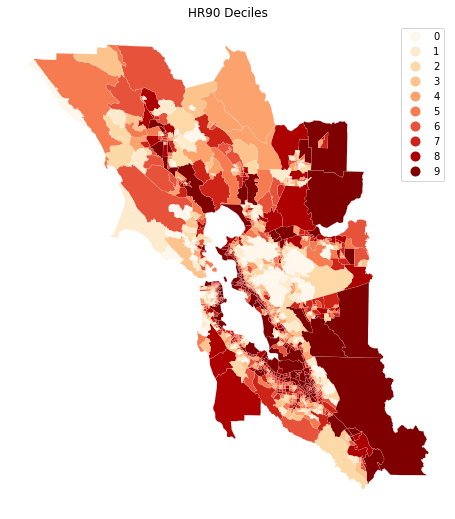

In [46]:
f, ax = plt.subplots(1, figsize=(9, 9))
gdf.assign(cl=varQ10.yb).plot(column='cl', categorical=True, \
        k=10, cmap='OrRd', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("HR90 Deciles")
plt.show()

In [44]:
# neighbor relations
w = lps.weights.Queen.from_dataframe(gdf)

# spatial lag
varLag = lps.weights.lag_spatial(w, gdf['Pollution'])

varLagQ10 = mc.Quantiles(varLag, k=10)
# feature = 'ozone'

# # load 

# hr10 = ps.Quantiles(data.HR90, k=10)

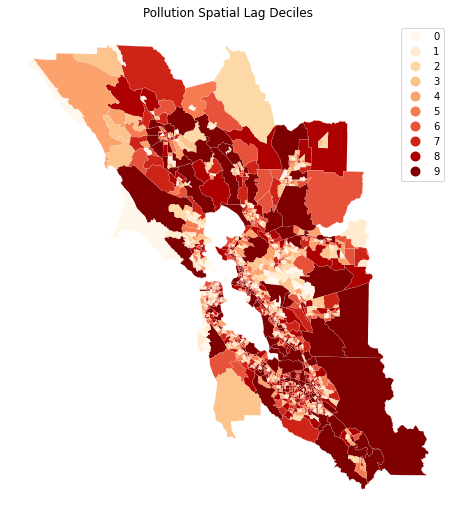

In [45]:
f, ax = plt.subplots(1, figsize=(9, 9))
gdf.assign(cl=varLagQ10.yb).plot(column='cl', categorical=True, \
        k=10, cmap='OrRd', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("{} Spatial Lag Deciles".format(var))

plt.show()

In [51]:
# spatial autocorrelation
varVal = gdf[var]
b,a = np.polyfit(varVal, varLag, 1)

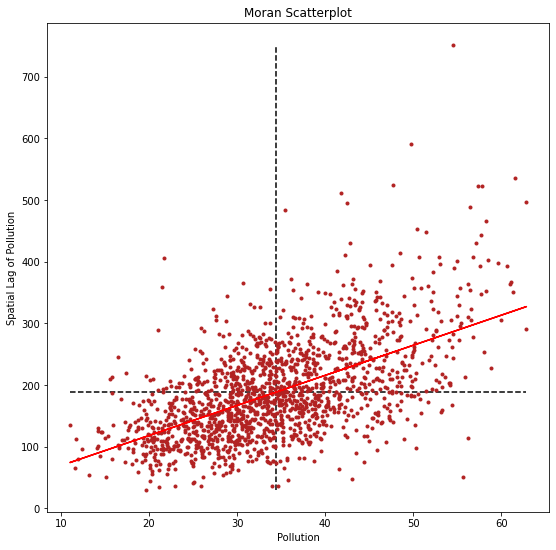

In [52]:
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(varVal, varLag, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(varVal.mean(), varLag.min(), varLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(varLag.mean(), varVal.min(), varVal.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(varVal, a + b*varVal, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of {}'.format(var))
plt.xlabel(var)
plt.show()

In [56]:
# Global Spatial Autocorrelation

# Moran's I statistic
I_var = mi = Moran(gdf[var],  w) 
I_var.I, I_var.p_sim

(0.6323677913104693, 0.001)

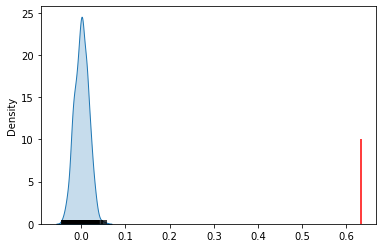

In [61]:
# visualize the distribution
sns.kdeplot(I_var.sim, shade=True)
plt.vlines(I_var.sim, 0, 0.5)
plt.vlines(I_var.I, 0, 10, 'r')
# plt.xlim([-0.2, 0.8])
pass

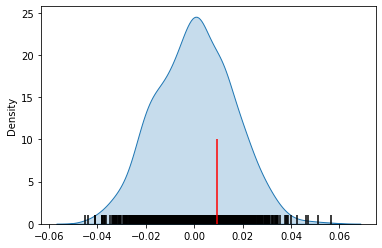

In [62]:
# if instead, I statistic closed to expected, then plot looks like:
sns.kdeplot(I_var.sim, shade=True)
plt.vlines(I_var.sim, 0, 1)
plt.vlines(I_var.EI+.01, 0, 10, 'r')
# plt.xlim([-0.15, 0.15])
pass

In [ ]:
# conclude that the map pattern is not spatially random

In [64]:
# Local Autocorrelation Statistics
LMo_var = Moran_Local(gdf[var], w)

In [65]:
# find all of the statistically significant LISAs
sigs = varVal[LMo_var.p_sim <= .001]
W_sigs = varLag[LMo_var.p_sim <= .001]
insigs = varVal[LMo_var.p_sim > .001]
W_insigs = varLag[LMo_var.p_sim > .001]

Text(0.5, 0, 'Pollution')

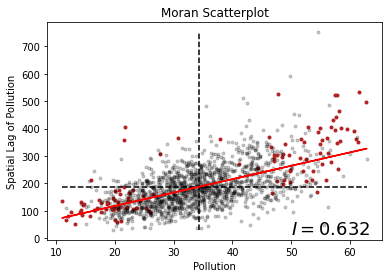

In [66]:
plt.plot(sigs, W_sigs, '.', color='firebrick')
plt.plot(insigs, W_insigs, '.k', alpha=.2)
 # dashed vert at mean of the last year's PCI
plt.vlines(varVal.mean(), varLag.min(), varLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(varLag.mean(), varVal.min(), varVal.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(varVal, a + b*varVal, 'r')
plt.text(s='$I = %.3f$' % I_var.I, x=50, y=15, fontsize=18)
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of {}'.format(var))
plt.xlabel(var)

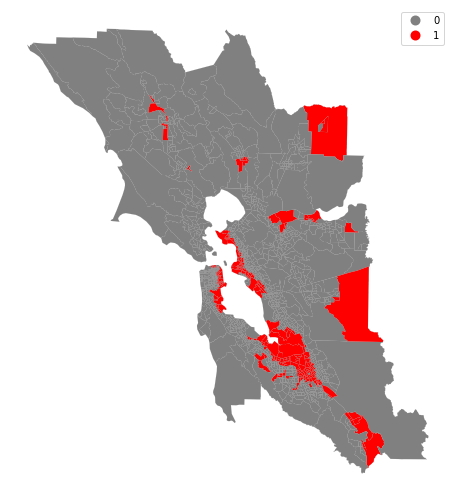

In [67]:
# LISA map of data
sig = LMo_var.p_sim < 0.05
hotspots = LMo_var.q==1 * sig
coldspots = LMo_var.q==3 * sig

hmap = colors.ListedColormap(['grey', 'red'])
f, ax = plt.subplots(1, figsize=(9, 9))
gdf.assign(cl=hotspots*1).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='grey', legend=True)
ax.set_axis_off()
plt.show()

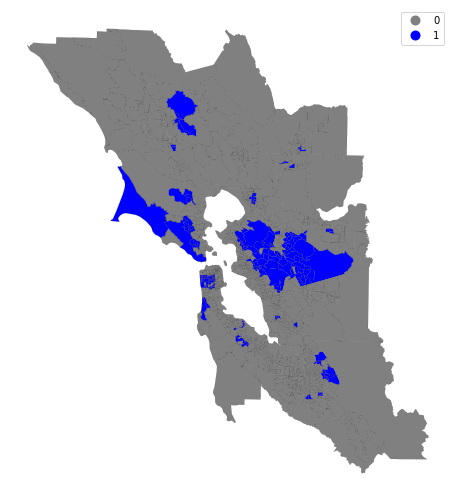

In [68]:
cmap = colors.ListedColormap(['grey', 'blue'])
f, ax = plt.subplots(1, figsize=(9, 9))
gdf.assign(cl=coldspots*1).plot(column='cl', categorical=True, \
        k=2, cmap=cmap, linewidth=0.1, ax=ax, \
        edgecolor='black', legend=True)
ax.set_axis_off()
plt.show()

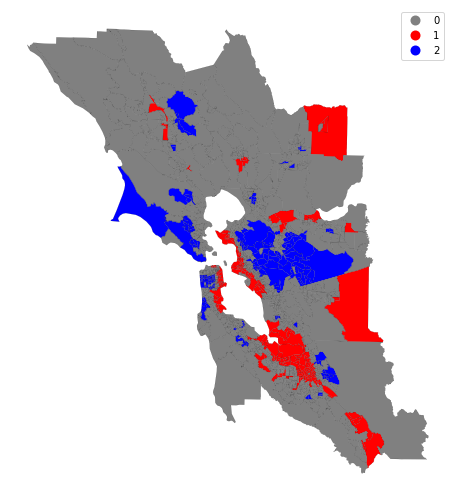

In [69]:
hcmap = colors.ListedColormap(['grey', 'red','blue'])
hotcold = hotspots*1 + coldspots*2
f, ax = plt.subplots(1, figsize=(9, 9))
gdf.assign(cl=hotcold).plot(column='cl', categorical=True, \
        k=2, cmap=hcmap,linewidth=0.1, ax=ax, \
        edgecolor='black', legend=True)
ax.set_axis_off()
plt.show()

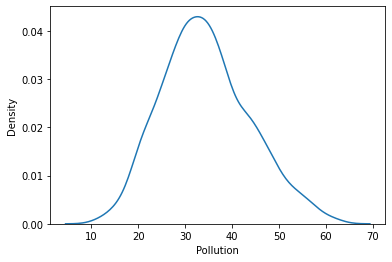

In [71]:
# distribution
sns.kdeplot(gdf[var])
pass